# Выпускной проект курса аналитики данных ЯПрактикума (когорта 99)

## Проект - Анализ оттока клиентов "Метанпром" банка

### Описание проекта:
  
  Заказчик - крупный региональный банк "Метанпром". Необходимо разобраться с динамикой оттока клиентов, выделить группы риска(сегменты). Т.к. для заказчика дешевле и приоритетнее для роста выручки оставлять действующих клиентов, то нашей задачей будет разобраться с оттоком и вывести рекомендации после проведения анализа полученных данных по клиентам банка.

#### Этапы проекта:

*Загрузим библиотеки для работы, загрузим данные* 
  
**Изучение и предобработка данных:**  
- Изучим и проверим данные на пропуски,дубликаты. Посмотрим типы данных, добавим столбцы, при необходимости. 
  

**Анализ данных, количественные показатели:**  
- Проанализируем категориальные и непрерывные показатели, анализ корреляциии показателей с параметром оттока
- Определим, какие признаки больше влияют на отточность клиентов
- Анализ портрета клиентов в разрезе оттока

**Статистические гипотезы:**  
- Доходы клиентов, которые ушли - меньше, чем клиентов, которые остаются
- Вторую гипотезу сформирую в процессе работы с данными

**Подведение промежуточных итогов:**  
- Опишем результаты предобработки, резюмируем заполнение пропусков(при его наличии), и оценим полноту и качество полученных данных
- Результаты исследовательского анализа данныз, корелляционного анализа 
- Результаты тестов по выдвинутым статистическим гипотезам
- Выделим признаки, которые влияют на отточность клиентов
  

**Сегментация:**  
- сегментирование клиентов по оттоку
- приоритизация сегментов

 **Выводы по анализу:**  
- Выводы по проведенному анализу, формирование рекомендаций на основании проведенной работы

### Ссылка на презентация с проектом https://disk.yandex.ru/i/0wsCY4RuoiKOOQ

In [1]:
pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org phik 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
import phik

In [3]:
try:
    data = pd.read_csv('C:/Users/kiselevvs/Desktop/Data analyst/datasets/bank_scrooge.csv')
except:
    data = pd.read_csv('https://')

###  <font color='blue'>Изучение и предобработка данных</font>

In [4]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [5]:
data.columns = map(str.lower, data.columns)
data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Для унифицирования работы и следования принципа кодинга на питоне, перевели названия столбцов в строчный регистр

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Видим, что имеются пропуски в колонка возраста (26 пропусков, менее 5% от общего количества), отнесем их к категории **MCAR** и в колонке баланса (2295 пропусков, более 20%), остнесем их к колонке **MNAR**  
Имеет смысл заполнить значения возраста, значения баланса заполнять не будем, чтобы не испортить данные

Добавим столбец в дадасет с признаком пропущенности значения, если в наблюдении пропущено значение, то он будет равен 1 и 0 если нет пропусков в наблюдении

In [7]:
missing_data = data.isnull()
missing_data

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,True,False,False,False,False,False
9997,False,False,False,False,False,False,True,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,False,False


In [8]:
data['balance'].isnull()

0       False
1       False
2        True
3       False
4       False
        ...  
9995    False
9996     True
9997     True
9998    False
9999    False
Name: balance, Length: 10000, dtype: bool

In [9]:
data[data['balance'].isnull()]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9976,208085,876.0,Ростов,М,38.0,0,NaN,1,0,0,171763.69,0
9984,125941,729.0,Ярославль,Ж,42.0,0,NaN,1,1,1,687538.70,0
9993,219924,884.0,Рыбинск,Ж,36.0,0,NaN,1,1,1,169844.88,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0


In [10]:
data['missed_balance'] = data['balance'].isnull() * 1
data['missed_age'] = data['age'].isnull() * 1
data


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0,0,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0,1,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0,1,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0,0,0


Создал столбец с признаком пропущенности значений в наблюдении, если значение пропущено missed_val_par == 1, если нет пропущенных в наблюдении missed_val_par == 0

In [11]:
phik_correlation = data.loc[:,~data.columns.isin(['userid'])].phik_matrix(interval_cols=['score', 'balance', 'est_salary', 'age'])
phik_correlation

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
score,1.000000,0.090984,0.071278,0.032750,0.527970,0.170897,0.309150,0.208683,0.052911,0.395681,0.229572,0.755046,0.059585
city,0.090984,1.000000,0.012720,0.091769,0.063431,0.039968,0.222573,0.074831,0.030531,0.171390,0.016811,0.040277,0.011859
gender,0.071278,0.012720,1.000000,0.286450,0.064554,0.045424,0.122547,0.196238,0.014156,0.144801,0.218799,0.097850,0.000000
age,0.032750,0.091769,0.286450,1.000000,0.046514,0.019169,0.133230,0.157632,0.090068,0.359738,0.191653,0.047756,NaN
equity,0.527970,0.063431,0.064554,0.046514,1.000000,0.000000,0.442391,0.221940,0.051091,0.286489,0.352726,0.975823,0.038201
balance,0.170897,0.039968,0.045424,0.019169,0.000000,1.000000,0.000000,0.000000,0.000000,0.374374,0.024701,NaN,0.000000
products,0.309150,0.222573,0.122547,0.133230,0.442391,0.000000,1.000000,0.459214,0.191403,0.157906,0.441363,0.793178,0.044816
credit_card,0.208683,0.074831,0.196238,0.157632,0.221940,0.000000,0.459214,1.000000,0.049761,0.038195,0.202997,0.245296,0.000000
last_activity,0.052911,0.030531,0.014156,0.090068,0.051091,0.000000,0.191403,0.049761,1.000000,0.046097,0.261174,0.041281,0.032798
est_salary,0.395681,0.171390,0.144801,0.359738,0.286489,0.374374,0.157906,0.038195,0.046097,1.000000,0.047661,0.430502,0.009403


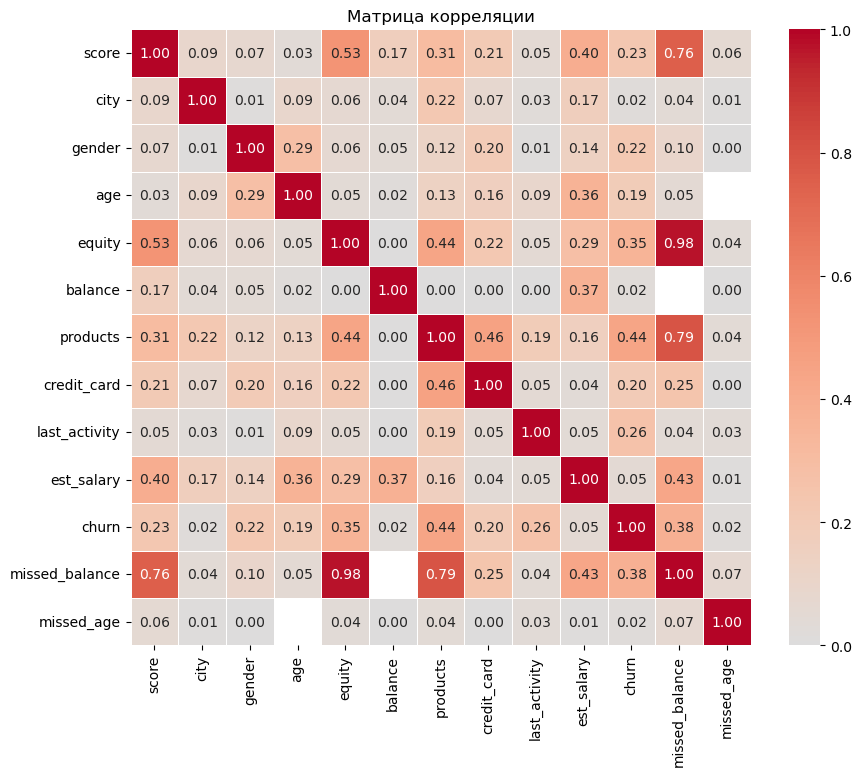

In [12]:
# Визуализируем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(phik_correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

Построил матрицу корреляции , чтобы посмотреть корреляцию с параметром пропущенности значений в наблюдении  
**Видим, что параметр пропущенности значений по колонке баланса сильно коррелирует, и зависит от**:  
- количества баллов собственности (0.98) - весьма высокая связь
- количества продуктов(0.79) - высокая связь
- баллов кредитного рейтинга (0.76) - высокая связь
- оценочного дохода(0.43) - высокая связь  
  
**по колонке возраста не коррелирует, связи нет**

Пропуски в колонке баланса могут зависеть от других значений, заполнять их, не испортив данные мы не можем

In [13]:
data['age'].describe()

count    9974.000000
mean       42.734409
std        12.179971
min        18.000000
25%        33.000000
50%        40.000000
75%        51.000000
max        86.000000
Name: age, dtype: float64

In [14]:
data.loc[data['age'].isna(), 'age'] = data['age'].median()

In [15]:
data.duplicated().sum()

0

Произвели проверку на наличие явных дубликатов, их нет

In [16]:
data.loc[:, ~data.columns.isin(['userid', 'churn'])].duplicated().sum()

0

In [17]:
data.duplicated('userid').sum()

73

In [18]:
data[data.duplicated('userid', keep=False)].sort_values('userid')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,0,0
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,1,0
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,1,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,0,0
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,226719,990.0,Ярославль,М,37.0,4,14648692.14,2,0,0,934412.61,1,0,0
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1,0,0
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0,0,0
6457,228075,839.0,Рыбинск,М,39.0,5,507199.85,3,0,1,85195.80,0,0,0


Произвели проверку на наличие неявных дубликатов, исключая колонки userid и колонку с признаком отточности  
Неявные дубликаты не обнаружены

Также произвели проверку дубликатов по столбцу 'userid' - дублирующих строк 73. Но при проверке этих строк обнаружили, что их нельзя отнести к дубликатам, так как большинство/все показатели разные.   
***Возможно, это связано с обособленным исчислением userid в каждом филиале или техническими ошибками при сборе данных***

In [19]:
data['city'].value_counts()

city
Ярославль    5888
Рыбинск      2695
Ростов       1417
Name: count, dtype: int64

In [20]:
data['gender'].value_counts()

gender
М    5005
Ж    4995
Name: count, dtype: int64

In [21]:
data['equity'].value_counts()

equity
0    2592
5    1918
4    1850
3    1543
2    1052
1     774
6     161
7      80
8      17
9      13
Name: count, dtype: int64

In [22]:
data['products'].value_counts()

products
2    5126
1    3341
3    1039
4     474
5      19
0       1
Name: count, dtype: int64

In [23]:
data['credit_card'].value_counts()

credit_card
1    6804
0    3196
Name: count, dtype: int64

In [24]:
data['last_activity'].value_counts()

last_activity
1    5235
0    4765
Name: count, dtype: int64

In [25]:
data['churn'].value_counts()

churn
0    8180
1    1820
Name: count, dtype: int64

Посмотрели уникальные значения в некоторых категориальных столбцах, чтобы обнаружить "выбросы" или ошибочные значения или аномалии  
Выбросов или аномалий не обнаружено

In [26]:
data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0


***Провели изучени и предобработку данных --  првели обработку пропусков, посомтрели на явные и неявные дубликаты и провелди наличие "выбросов" в данных***

###  <font color='blue'>**Анализ данных, количественные показатели**</font>

In [27]:
churn_rate = data['churn'].mean() * 100
print(f'Средний процент оттока клиентов банка составляет {churn_rate}%')

Средний процент оттока клиентов банка составляет 18.2%


In [28]:
data_hist = data.copy()

***Преобразование данных: кодирование категориальных признаков***

In [30]:
data_with_coder = data.copy()
data_with_coder.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0


In [31]:
data_with_coder['city_coder'] = data_with_coder['city']
data_with_coder['gender_coder'] = data_with_coder['gender']

In [32]:
data_with_coder = pd.get_dummies(data_with_coder, columns = ['city_coder', 'gender_coder'], prefix = '', prefix_sep = '')
data_with_coder.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age,Ростов,Рыбинск,Ярославль,Ж,М
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0,False,True,False,True,False
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0,False,True,False,True,False
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0,False,True,False,True,False
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,False,False,True,True,False
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,False,False,True,False,True


In [33]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style("white")

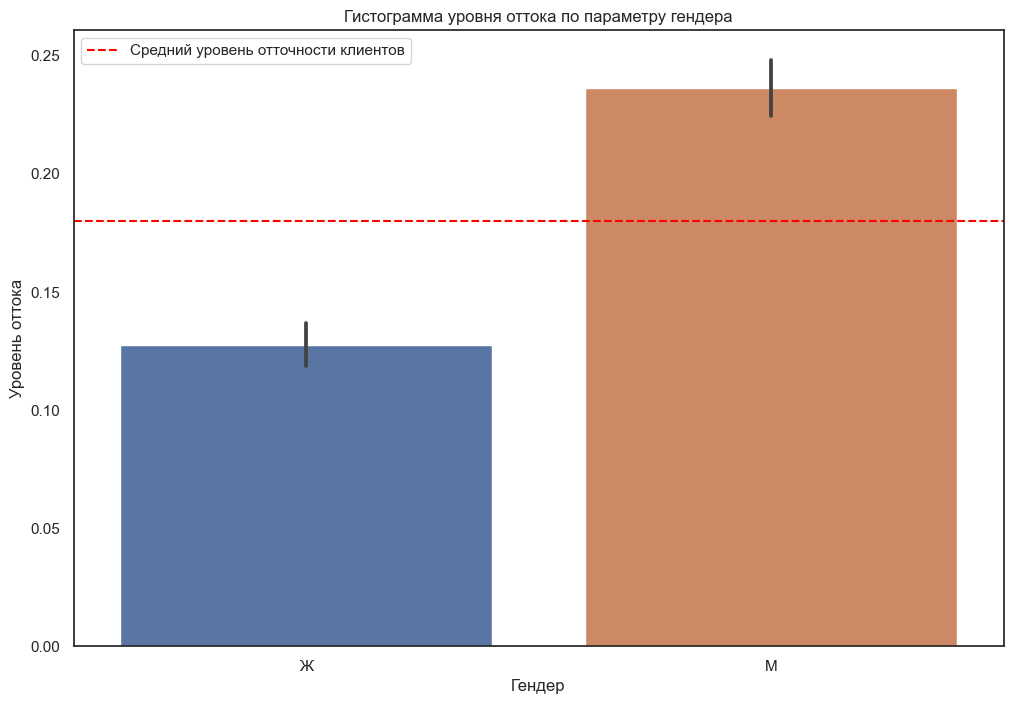

In [34]:
sns.barplot(data=data, x='gender', y='churn');
plt.axhline(0.18, c='red', linestyle='dashed', label = "Средний уровень отточности клиентов")
plt.legend()
plt.title('Гистограмма уровня оттока по параметру гендера');
plt.xlabel('Гендер');
plt.ylabel('Уровень оттока');

Построили гистограмму по дискретному признаку гендера с горизонтальной линией обозначающей средний отток по датасету  
Видим, что отток у мужчин выше предельной линии среднего оттока и равен около 0.23

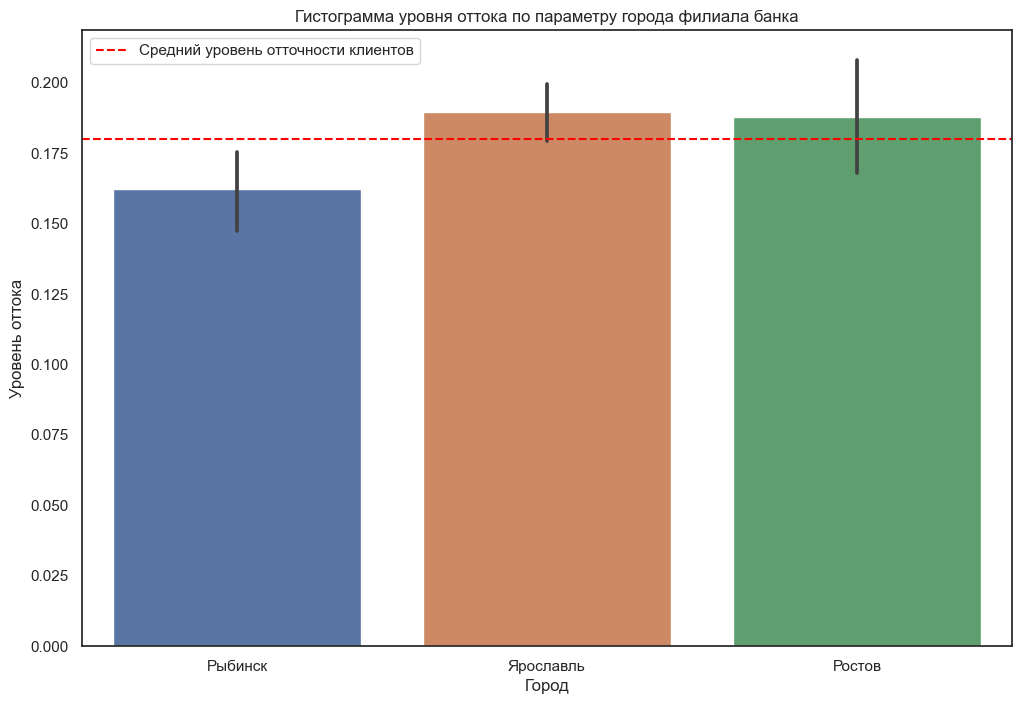

In [36]:
sns.barplot(data=data, x='city', y='churn');
plt.axhline(0.18, c='red', linestyle='dashed', label = "Средний уровень отточности клиентов")
plt.legend()
plt.title('Гистограмма уровня оттока по параметру города филиала банка');
plt.xlabel('Город');
plt.ylabel('Уровень оттока');

Построили гистограмму по дискретному признаку города филиала банка с горизонтальной линией обозначающей средний отток по датасету  
Видим, что отток у в Ярославле и Ростове выше предельной линии среднего оттока и равен около 0.19

In [37]:
bins_age = int(data_hist['age'].max() - data_hist['age'].min())
bins_age

68

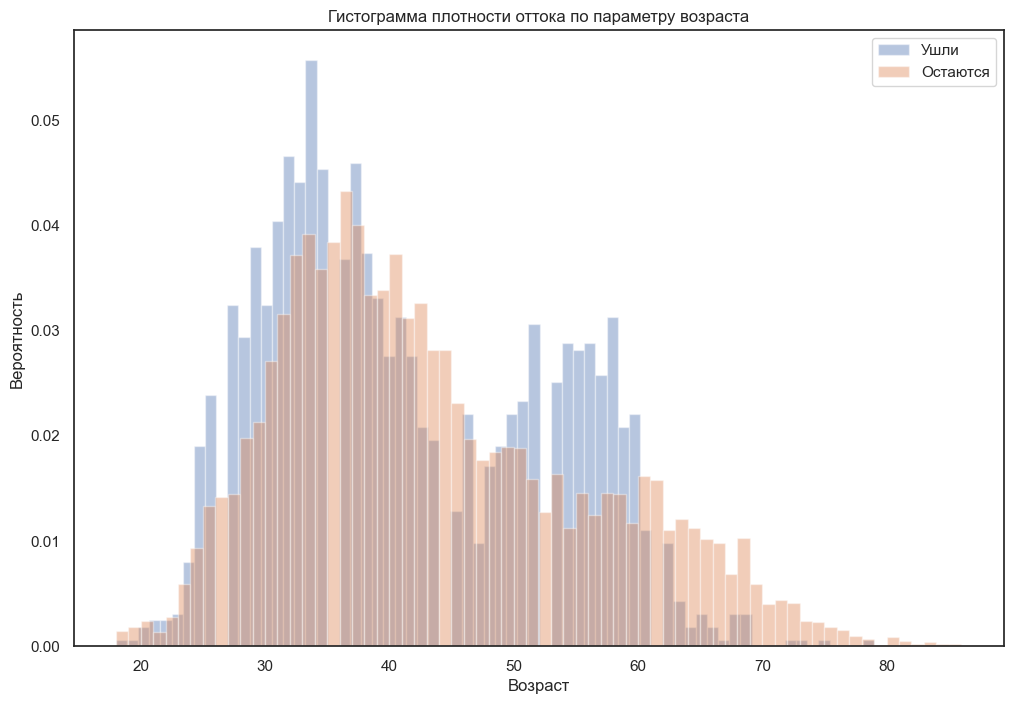

In [38]:
sns.distplot(data_hist.loc[data_hist['churn'] == 1, 'age'], norm_hist=True, kde=False, bins=bins_age, label='Ушли');
sns.distplot(data_hist.loc[data_hist['churn'] == 0, 'age'], norm_hist=True, kde=False, bins=bins_age, label='Остаются');
plt.title('Гистограмма плотности оттока по параметру возраста');
plt.xlabel('Возраст');
plt.ylabel('Вероятность');
plt.legend();

Построили гистограмму плотности по параметру возраста, и видим, что у категории клиентов:  
- 24-35 лет --  вероятность оттока выше, чем средняя
- 37-38 лет --  вероятность оттока выше, чем средняя
- 46 лет --  вероятность оттока выше, чем средняя
- 49-52 лет --  вероятность оттока выше, чем средняя
- 54-60 лет --  вероятность оттока выше, чем средняя

In [39]:
bins_score = int(data_hist['score'].max() - data_hist['score'].min())
bins_score

358

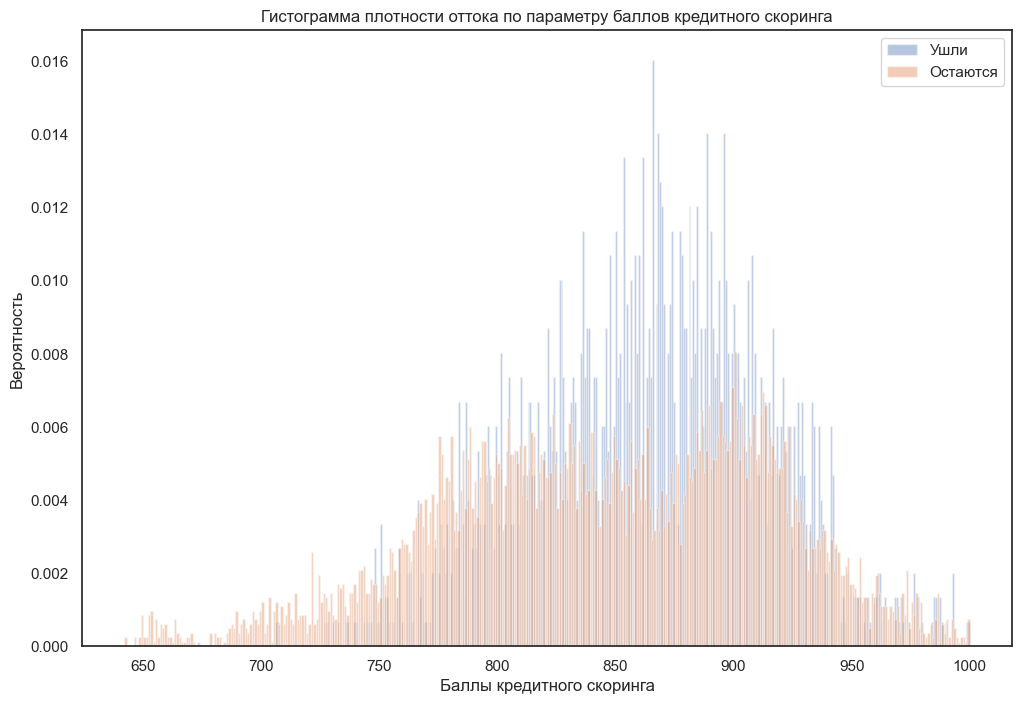

In [40]:
sns.distplot(data_hist.loc[data_hist['churn'] == 1, 'score'], norm_hist=True, kde=False, bins=bins_score, label='Ушли');
sns.distplot(data_hist.loc[data_hist['churn'] == 0, 'score'], norm_hist=True, kde=False, bins=bins_score, label='Остаются');
plt.title('Гистограмма плотности оттока по параметру баллов кредитного скоринга');
plt.xlabel('Баллы кредитного скоринга');
plt.ylabel('Вероятность');
plt.legend();

Построили гистограмму плотности по параметру баллов кредитного скоринга, и видим, что:  
- в диапазоне 780 -- 930 вероятность оттока выше чем средняя

In [41]:
bins_equity = int(data_hist['equity'].max() - data_hist['equity'].min())
bins_equity

9

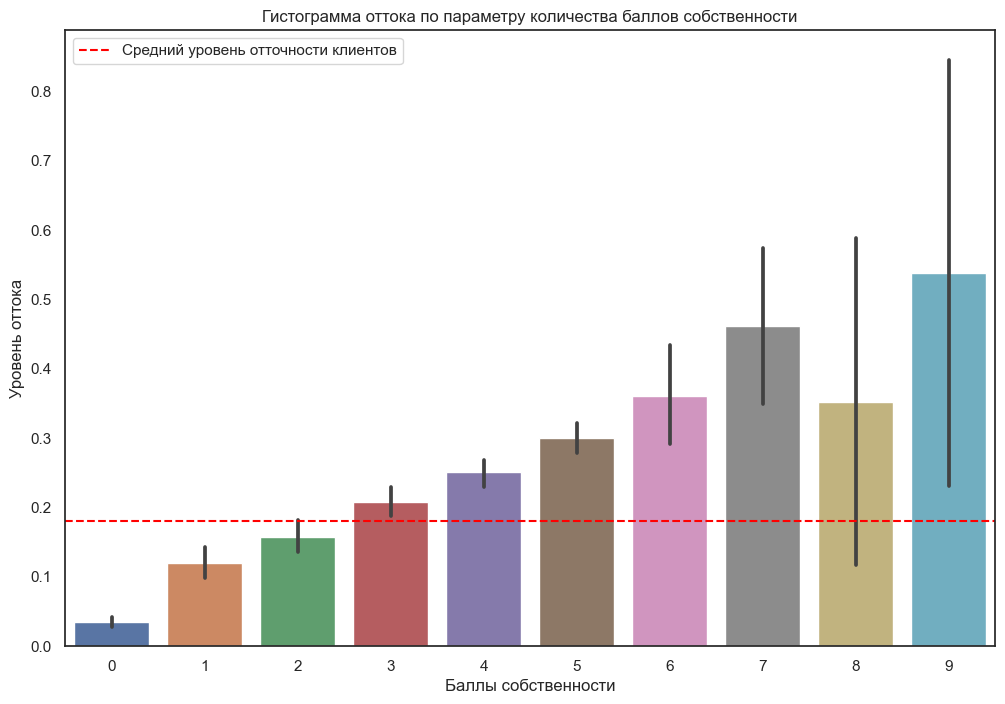

In [43]:
sns.barplot(data=data, x='equity', y='churn');
plt.axhline(0.18, c='red', linestyle='dashed', label = "Средний уровень отточности клиентов")
plt.legend()
plt.title('Гистограмма оттока по параметру количества баллов собственности');
plt.xlabel('Баллы собственности');
plt.ylabel('Уровень оттока');

Начиная с 3 баллов собственности вероятность оттока клиентов выше, чем средняя вероятность по этому параметру

In [44]:
data_hist['balance'].sort_values()

6757     0.0
3900     0.0
6164     6.0
3918     7.0
2876    20.0
        ... 
9976     NaN
9984     NaN
9993     NaN
9996     NaN
9997     NaN
Name: balance, Length: 10000, dtype: float64

In [45]:
data_hist['balance'].max() - data_hist['balance'].min()

119113552.01

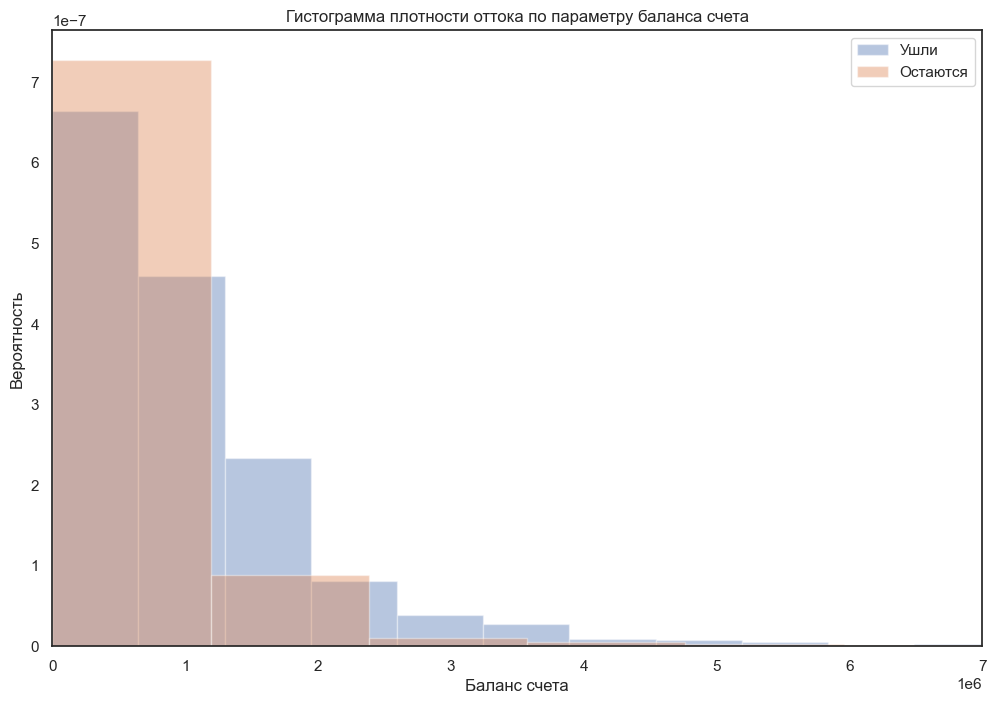

In [46]:
sns.distplot(data_hist.loc[data_hist['churn'] == 1, 'balance'], norm_hist=True, kde=False, bins=100, label='Ушли');
sns.distplot(data_hist.loc[data_hist['churn'] == 0, 'balance'], norm_hist=True, kde=False, bins=100, label='Остаются');
plt.title('Гистограмма плотности оттока по параметру баланса счета');
plt.xlabel('Баланс счета');
plt.ylabel('Вероятность');
plt.xlim(0, 0.7*10**7)
plt.legend();

Построили гистограмму распределения плотности оттока (с лимитом по балансу 7 000 000 р)  
Видим, что уровень оттока выше у клиентов с балансом более 1 млн.руб.

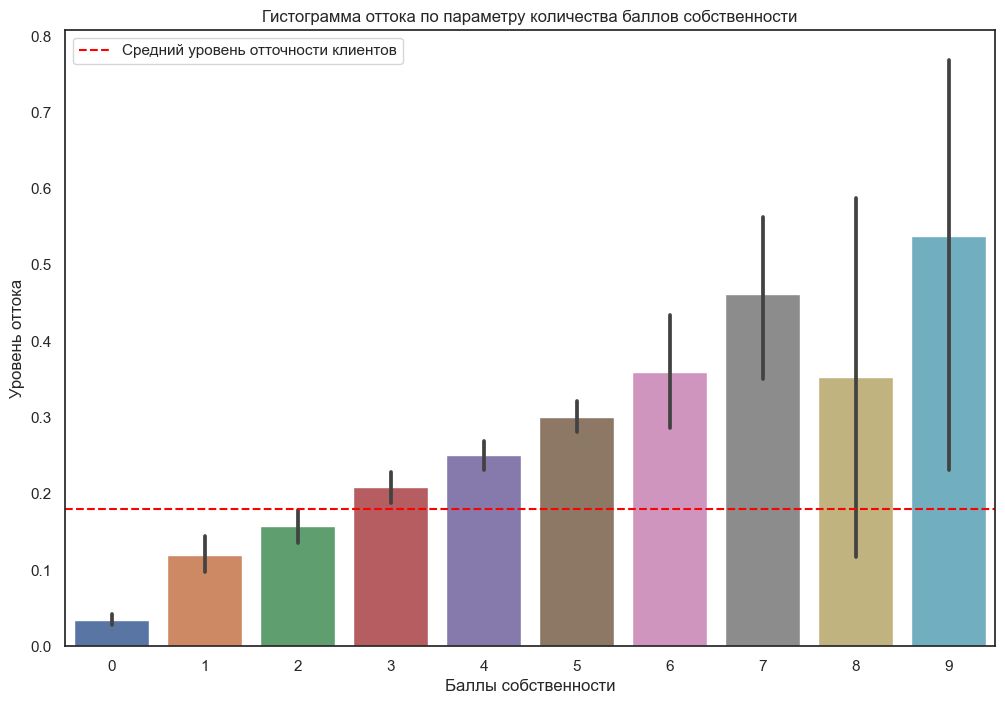

In [47]:
sns.barplot(data=data, x='equity', y='churn');
plt.axhline(0.18, c='red', linestyle='dashed', label = "Средний уровень отточности клиентов")
plt.legend()
plt.title('Гистограмма оттока по параметру количества баллов собственности');
plt.xlabel('Баллы собственности');
plt.ylabel('Уровень оттока');

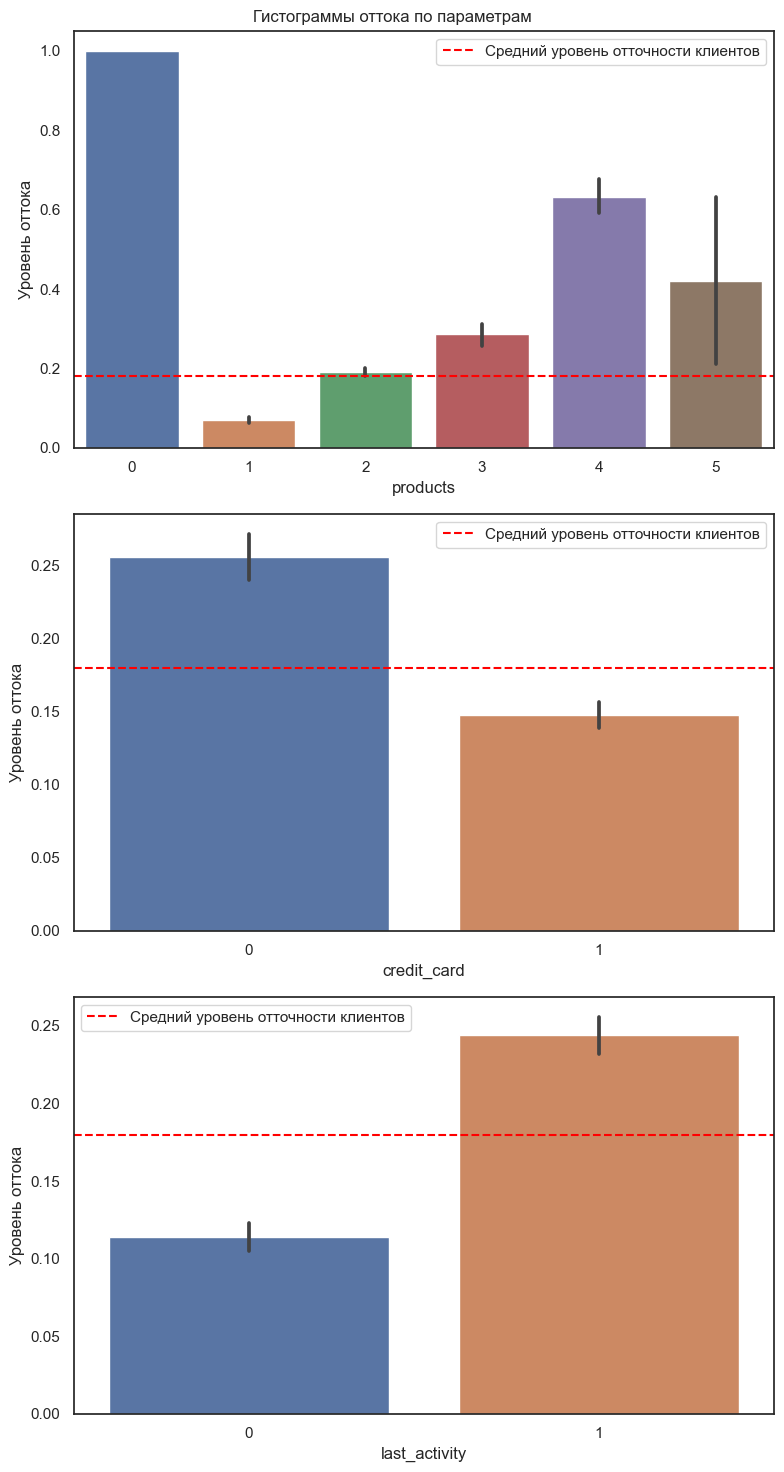

In [48]:
parameters = ['products', 'credit_card', 'last_activity']
fig = plt.figure(figsize = (8, 15))
fig.subplots_adjust(hspace = 0.4)
i = 1
for param in parameters:
    ax = fig.add_subplot(3, 1, i)
    sns.barplot(data=data, x= param, y='churn');
    plt.axhline(0.18, c='red', linestyle='dashed', label = "Средний уровень отточности клиентов")
    plt.legend()
    ax.set_ylabel('Уровень оттока')
    ax.set(xlabel = param)
    i += 1


fig.suptitle('Гистограммы оттока по параметрам', fontsize=12);
fig.tight_layout()

In [49]:
data[data['products'] == 0]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1,1,0


In [50]:
data.drop(data[data['products'] == 0].index, inplace=True)

Удалили наблюдение, в котором количество банковских продкутов равно 0, т.к. это противоречит логике статуса "клиент" или "бывший клиент"

**Видим, что:**
- при 2-5 продуктах у клиента -- вероятность оттока выше
- при отсутствии кредитной вероятность оттока выше
- ***параметр активности считаю, что не стоит связывать с оттоком, т.к. клиент может не делать никаких действий и оставаться клиентом де-юро, но не быть им де-факто. Также наоборот подача заявки на закрытие счетов будет считаться показателем активности. Поэтому этот параметр для сегментации учитывать не будем***

In [51]:
data_hist['est_salary'].sort_values()

8783       2546.30
2186       3487.33
1753       5043.14
4860       5341.50
1700       7054.82
           ...    
5160    1296838.08
1600    1307090.18
4473    1333687.36
4637    1363549.52
4005    1395064.45
Name: est_salary, Length: 10000, dtype: float64

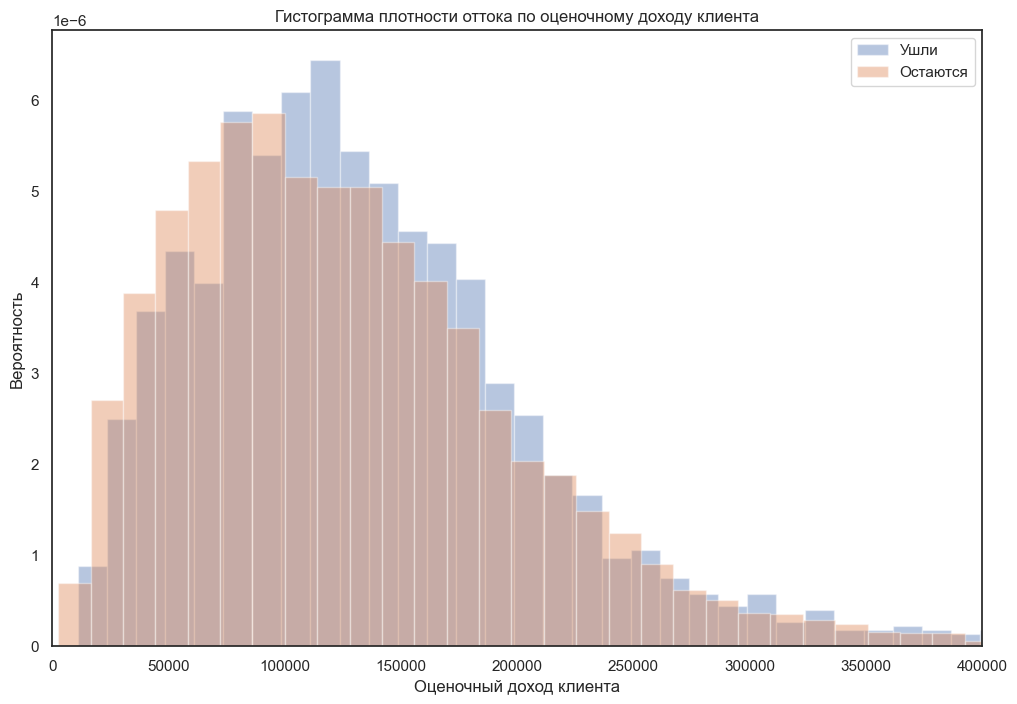

In [52]:
sns.distplot(data_hist.loc[data_hist['churn'] == 1, 'est_salary'], norm_hist=True, kde=False, bins=100, label='Ушли');
sns.distplot(data_hist.loc[data_hist['churn'] == 0, 'est_salary'], norm_hist=True, kde=False, bins=100, label='Остаются');
plt.xlim([0, 400000])
plt.title('Гистограмма плотности оттока по оценочному доходу клиента');
plt.xlabel('Оценочный доход клиента');
plt.ylabel('Вероятность');
plt.legend();

***Видим, что при доходе свыше 100 тыс.руб. вероятность оттока клиентов из нашего банка увеличивается***

In [53]:
data_with_coder.loc[:,~data_with_coder.columns.isin(['userid', 'city', 'gender'])]

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age,Ростов,Рыбинск,Ярославль,Ж,М
0,850.0,25.0,1,59214.82,2,0,1,75719.14,1,0,0,False,True,False,True,False
1,861.0,37.0,5,850594.33,3,1,0,86621.77,0,0,0,False,True,False,True,False
2,892.0,30.0,0,NaN,1,1,1,107683.34,0,1,0,False,True,False,True,False
3,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,False,False,True,True,False
4,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,0,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,814.0,27.0,1,78144.65,1,0,1,18943.64,0,0,0,False,True,False,False,True
9996,894.0,46.0,0,NaN,1,1,0,196898.29,0,1,0,False,False,True,False,True
9997,903.0,24.0,0,NaN,2,1,1,108905.09,0,1,0,False,False,True,False,True
9998,777.0,68.0,3,865457.97,3,0,1,86874.90,0,0,0,False,False,True,True,False


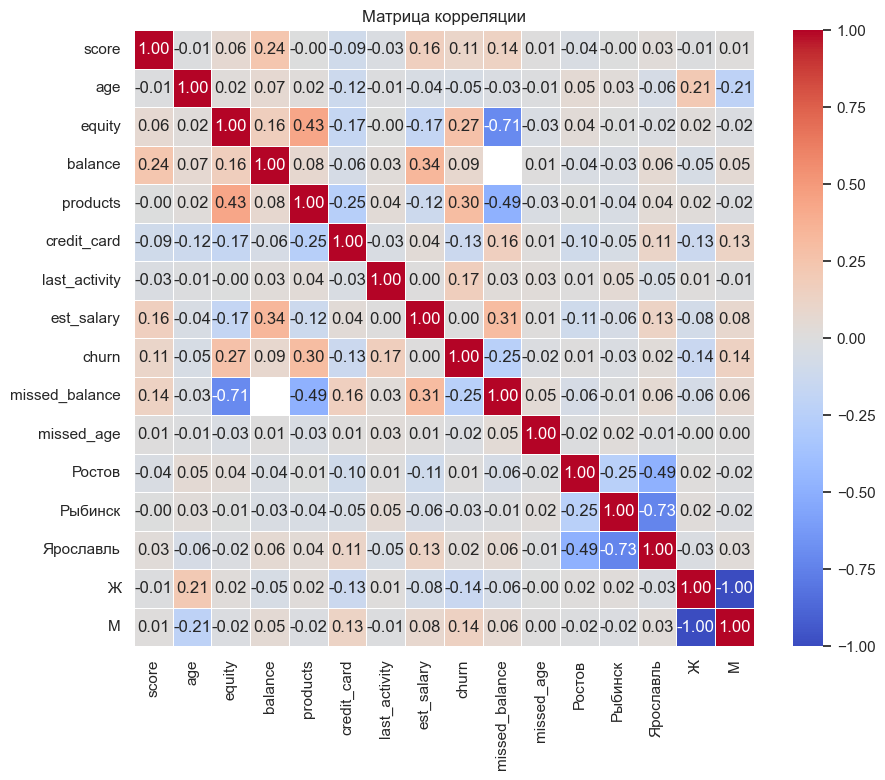

In [54]:
# Построим матрицу корреляции между признаками
correlation_matrix = data_with_coder.loc[:,~data_with_coder.columns.isin(['userid', 'city', 'gender'])].corr()

# Визуализируем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

***Построили тепловую карту корреляции***:
- Слабая связь параметра оттока с количеством баллов собственности
- Слабая связь параметра оттока с количеством продуктов

In [55]:
phik_correlation = data_with_coder.loc[:,~data_with_coder.columns.isin(['userid', 'city', 'gender'])].phik_matrix(interval_cols=['score', 'balance', 'est_salary', 'age'])
phik_correlation

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age,Ростов,Рыбинск,Ярославль,Ж,М
score,1.000000,0.032050,0.527970,0.170897,0.309150,0.208683,0.052911,0.395681,0.229572,0.755046,0.059585,0.086707,0.027672,0.083902,0.071278,0.071278
age,0.032050,1.000000,0.047888,0.019328,0.133850,0.157579,0.087601,0.359263,0.192376,0.049980,0.125878,0.067953,0.058029,0.094381,0.286123,0.286123
equity,0.527970,0.047888,1.000000,0.000000,0.442391,0.221940,0.051091,0.286489,0.352726,0.975823,0.038201,0.065462,0.000000,0.054950,0.064554,0.064554
balance,0.170897,0.019328,0.000000,1.000000,0.000000,0.000000,0.000000,0.374374,0.024701,NaN,0.000000,0.000000,0.023207,0.047921,0.045424,0.045424
products,0.309150,0.133850,0.442391,0.000000,1.000000,0.459214,0.191403,0.157906,0.441363,0.793178,0.044816,0.075924,0.145330,0.183940,0.122547,0.122547
credit_card,0.208683,0.157579,0.221940,0.000000,0.459214,1.000000,0.049761,0.038195,0.202997,0.245296,0.000000,0.152788,0.076669,0.178614,0.196238,0.196238
last_activity,0.052911,0.087601,0.051091,0.000000,0.191403,0.049761,1.000000,0.046097,0.261174,0.041281,0.032798,0.000000,0.074618,0.074923,0.014156,0.014156
est_salary,0.395681,0.359263,0.286489,0.374374,0.157906,0.038195,0.046097,1.000000,0.047661,0.430502,0.009403,0.136170,0.101571,0.176151,0.144801,0.144801
churn,0.229572,0.192376,0.352726,0.024701,0.441363,0.202997,0.261174,0.047661,1.000000,0.381123,0.020515,0.000000,0.046001,0.033644,0.218799,0.218799
missed_balance,0.755046,0.049980,0.975823,NaN,0.793178,0.245296,0.041281,0.430502,0.381123,1.000000,0.068092,0.094651,0.014012,0.085933,0.097850,0.097850


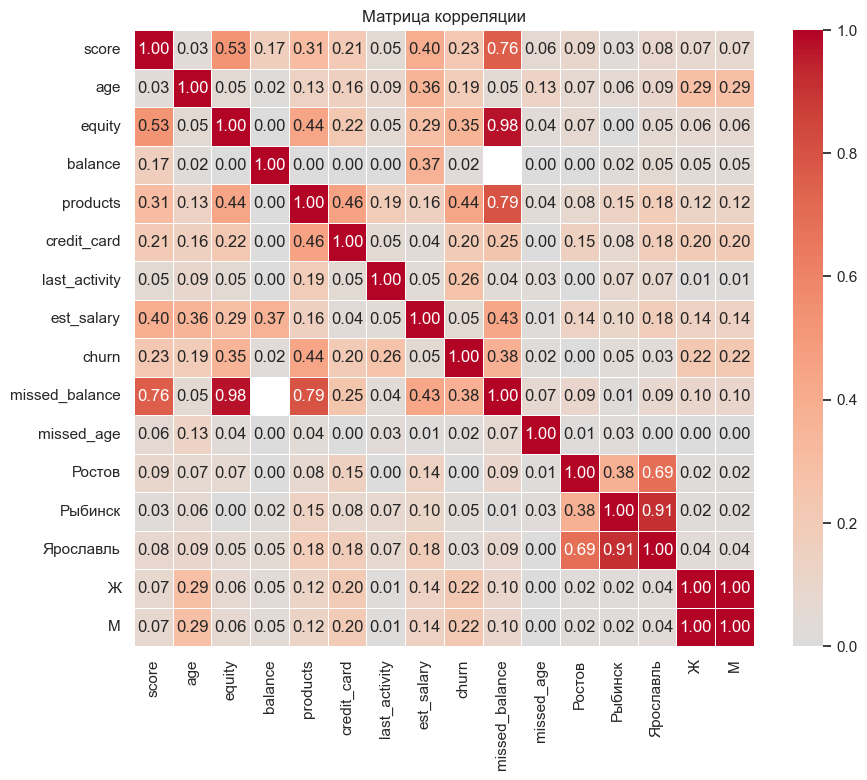

In [56]:
# Визуализируем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(phik_correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

***Построили тепловую карту корреляции c расчетом корреляции библиотекой phik
значение параметров корреляции изменилось***:
- Слабая связь параметра оттока с параметрами: баллов кредитного рейтинга, возраста, наличия кредитного продукта, последней активности, и разбивки по полу
- Нет заметной связи параметра оттока с параметрами: баланса, дохода, городов расположения филала
- Умеренная связь параметра оттока с параметрами: количества продуктов и количеством баллов собственности

In [57]:
phik_correlation_graph = phik_correlation.drop(['churn', 'missed_balance', 'missed_age'])
phik_correlation_graph = phik_correlation_graph['churn'].sort_values()
phik_correlation_graph

Ростов           0.000000
balance          0.024701
Ярославль        0.033644
Рыбинск          0.046001
est_salary       0.047661
age              0.192376
credit_card      0.202997
Ж                0.218799
М                0.218799
score            0.229572
last_activity    0.261174
equity           0.352726
products         0.441363
Name: churn, dtype: float64

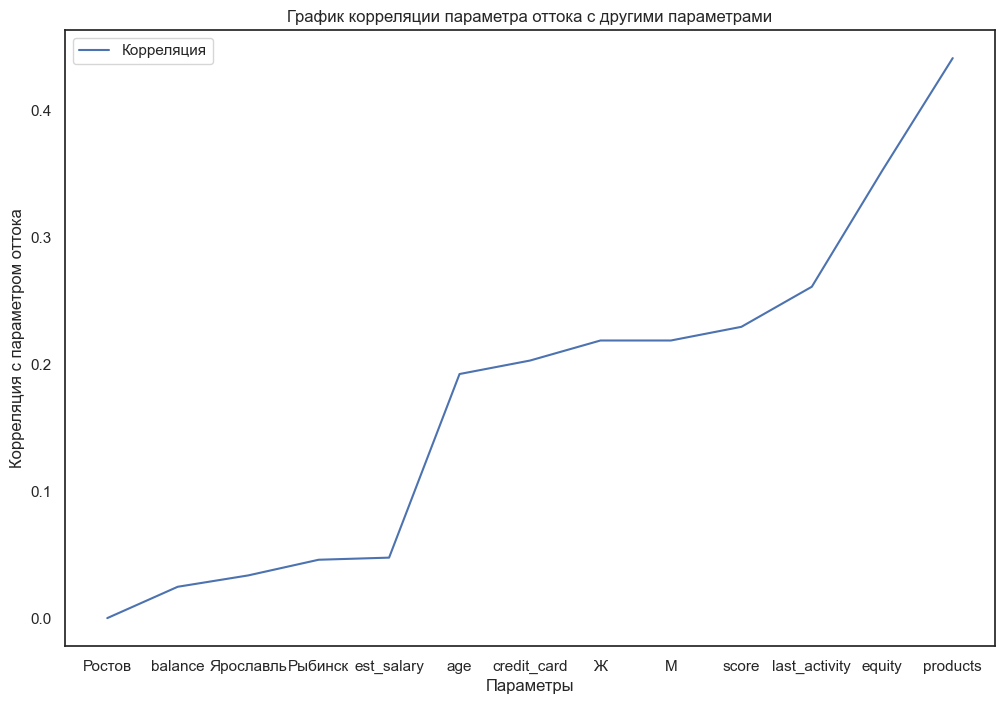

In [58]:
sns.lineplot(data = phik_correlation_graph, label="Корреляция");
plt.legend()
plt.title('График корреляции параметра оттока с другими параметрами');
plt.xlabel('Параметры');
plt.ylabel('Корреляция с параметром оттока');

По графику видим, что наибольший коэффициент корреляции оттока с количеством продуктов пользователя

In [59]:
data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0


In [60]:
def mode_custom(x):
    return x.mode()

In [61]:
mode_custom(data['city'])

0    Ярославль
Name: city, dtype: object

т.к. в pivot table не получается применять mode в aggfunc, определил собственную функцию для нахождения моды в pivot_table

In [62]:
data_client = data.pivot_table(index='churn',
                               values=['age', 'city', 'gender', 'est_salary', 'score',  'equity', 'products', 'credit_card', 'balance', 'last_activity'],
                                aggfunc={'age': 'mean', 'city': mode_custom, 'gender': mode_custom, 'est_salary': 'mean', 'score': 'mean',  'equity': 'median', 'products': 'median', 'credit_card': 'median', 'balance': 'median', 'last_activity': mode_custom},)
data_client.reset_index(inplace=True)
data_client

,churn,age,balance,city,credit_card,equity,est_salary,gender,last_activity,products,score
0,0,43.011614,475382.445,Ярославль,1,3,147783.200108,Ж,0,2,845.428362
1,1,41.428807,782410.470,Ярославль,1,4,148310.728202,М,1,2,863.346894


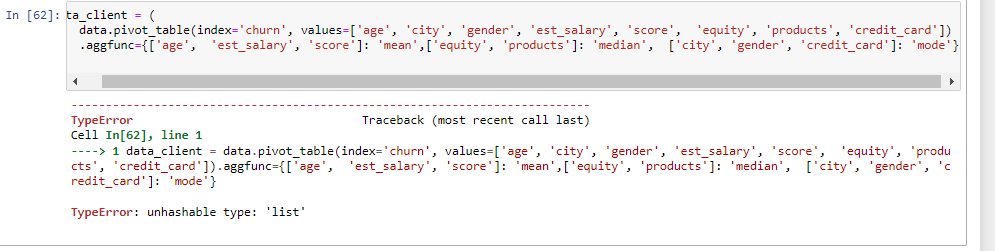

Пробовал записать применение функции к списку столбцов, почемуто ругается  
Видимо делаю чтото не так)

In [63]:
data_client = data_client.round(({'age': 0, 'est_salary': 0, 'score': 0})).transpose()
data_client.columns = ['client', 'churn']
data_client

,client,churn
churn,0,1
age,43.0,41.0
balance,475382.445,782410.47
city,Ярославль,Ярославль
credit_card,1,1
equity,3,4
est_salary,147783.0,148311.0
gender,Ж,М
last_activity,0,1
products,2,2


In [64]:
data_client['relative_diff, %'] = np.nan
data_client.iloc[[1, 2, 5, 6, 10], 2] = (data_client.iloc[[1, 2, 5, 6, 10], 0] - data_client.iloc[[1, 2, 5, 6, 10], 1]) / data_client.iloc[[1, 2, 5, 6, 10], 0]
data_client.iloc[[1, 2, 5, 6, 10], 2] = data_client.iloc[[1, 2, 5, 6, 10], 2].astype(float).round(2) * 100
data_client

,client,churn,"relative_diff, %"
churn,0,1,NaN
age,43.0,41.0,5.0
balance,475382.445,782410.47,-65.0
city,Ярославль,Ярославль,NaN
credit_card,1,1,NaN
equity,3,4,-33.0
est_salary,147783.0,148311.0,-0.0
gender,Ж,М,NaN
last_activity,0,1,NaN
products,2,2,NaN


**Создал таблицу с типовым портертом клиента банка и отточного клиента, а также с отеносительной разницей между ними**

Усредненный портрет отточного клиента и клиента, который остается в банке:  
  
**Клиент банка:**
- Усредненный возраст около 43 лет
- Баланс на счетах клиента усредненно равен 400 - 500 тыс.руб.
- Город Ярославль
- Пользуется кредитными продуктами
- Количество баллов собственности равно 3
- Оценочный доход равен 147 тыс. руб.
- Чаще всего клиент женского пола
- Имеет 2 банковских продукта
- Бал кредитного рейтинга около 845
  
**Клиент ушедший из банка:**
- Усредненный возраст около 41 года
- Баланс на счетах клиента усредненно равен более 750 тыс.руб.
- Город Ярославль
- Пользуется кредитными продуктами
- Количество баллов собственности равно 4
- Оценочный доход равен 148 тыс. руб.
- Чаще всего клиент мужского пола 
- Имеет 2 банковских продукта
- Бал кредитного рейтинга около 863 

Можем заметить, что наиболее заметная в усредененных портертах разница между клиентами банка и отточными клиентами состоит в:
1. Бывшый баланс на счетах отточных клиентов заметно выше
2. Количество баллов собственности отточных клиентов зачатую выше
3. Чаще в отточные клиенты попадают мужчины

###  <font color='blue'>**Статистические гипотезы**</font>

### Проверим гипотезу о том,что доходы клиентов, которые ушли - меньше, чем тех, кто остается клиентом

**Нулевая гипотеза(H0) - средние доходы клиентов банка и отточных клиентов одинаковы**
  
**альтернативная(H1) - средние доходы клиентов банка выше, чем у отточных клиентов**
  
Статистический тест для такой гиотезы выберем односторонний (greater)
  
Уровень статистической значимости выберем 0.05

<p><b>Использование t-теста имеет определенные ограничения, которые необходимо учитывать при его применении:</b><br>
- <i>Нормальное распределение данных:</i> t-тест предполагает, что данные имеют нормальное распределение. Если данные не соответствуют этому предположению, то результаты теста могут быть недостоверными. При выборках более 30 значений нормальность выборки не важна, с учетом того, что в реальных бизнес-процессах нормального распределения данных ни когда не бывает.<br>
- <i>Равномерное распределение данных в каждой группе:</i> t-тест предназначен для сравнения средних значений двух независимых выборок. Поэтому важно, чтобы в каждой группе (выборке) было достаточное количество наблюдений и они были равномерно распределены.<br>
- <i>Независимость выборок:</i> t-тест предполагает, что выборки, которые сравниваются, являются независимыми. Если наблюдения в одной выборке зависят от наблюдений в другой выборке (например, в случае последовательных временных точек), то необходимо использовать другие статистические методы.<br>
- <i>Достаточно большой размер выборки:</i> для получения достоверных результатов t-теста необходимо, чтобы размер каждой выборки был достаточно большим. Минимальные требования к размеру выборки зависят от уровня значимости.<br> 
- <i>Отсутствие выбросов:</i> t-тест чувствителен к выбросам в данных, поэтому важно убедиться, что в данных нет экстремальных значений, которые могут исказить результаты.<br>
- <i>Однородность дисперсий:</i> t-тест предполагает, что дисперсии (разбросы) данных в каждой выборке примерно одинаковы. Если это не так, то следует использовать параметр `equal_var` равным `False`.</p></font>

In [65]:
data_churn = data[data['churn'] == 1]
data_client= data[data['churn'] == 0]

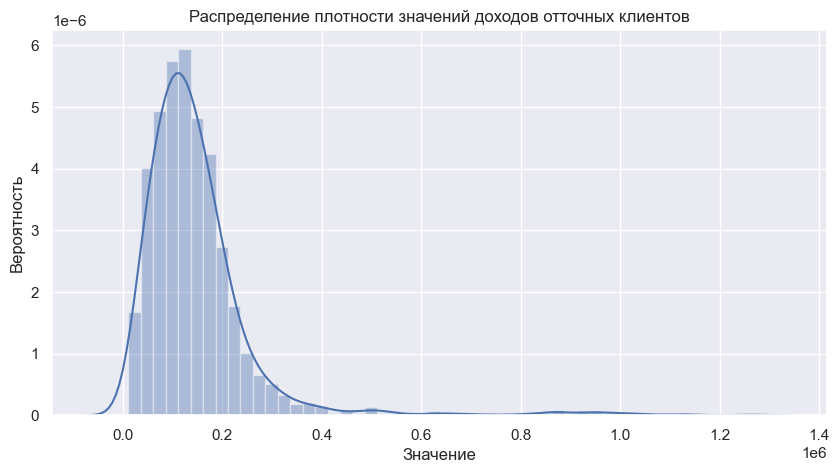

In [66]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.distplot(data_churn['est_salary'], kde=True)
plt.title('Распределение плотности значений доходов отточных клиентов');
plt.xlabel('Значение');
plt.ylabel('Вероятность');

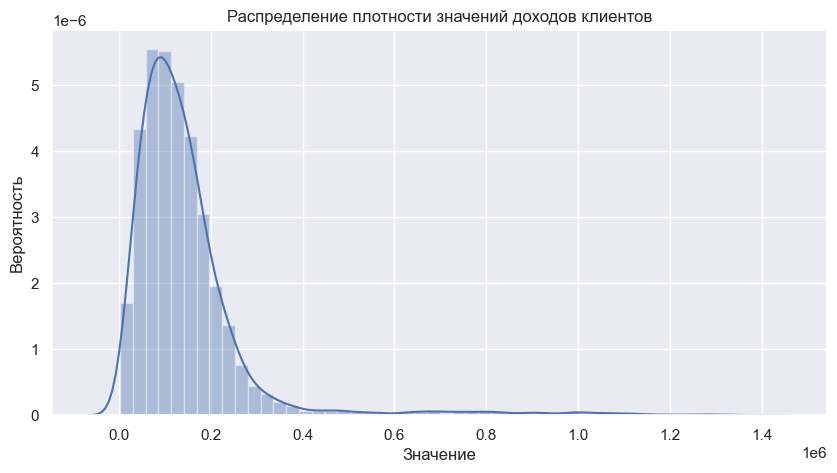

In [67]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.distplot(data_client['est_salary'], kde=True)
plt.title('Распределение плотности значений доходов клиентов');
plt.xlabel('Значение');
plt.ylabel('Вероятность');

Построили гистограммы распределения:
Распределения значений дохода не идеально описывает "нормальное" распределение, но с учетом ЦПТ  
***" ... Центральная предельная теорема утверждает, что выборочное распределение среднего значения выборки приблизительно нормально, если размер выборки достаточно велик, даже если распределение населения не является нормальным ... "***   

С учетом того, что наши выборки имеют относительно большое количество наблюдений (более 1000), будем считать, что мы не противоречим использованию t-теста

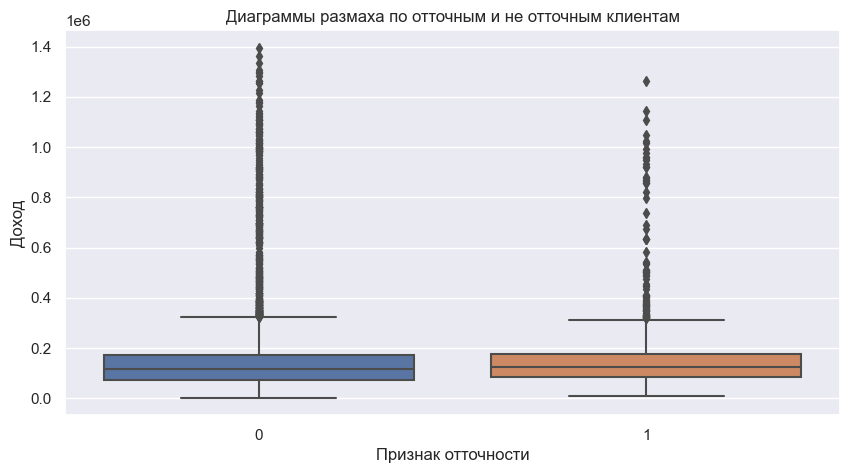

In [68]:
sns.boxplot(data=data, x='churn', y='est_salary')
plt.title('Диаграммы размаха по отточным и не отточным клиентам');
plt.xlabel('Признак отточности');
plt.ylabel('Доход');

По диаграммам размаха видно, что некоторые значения находятся вше третьего квартиля, но они не идиничны и считать их явными выбросами нельзя

По диаграммам размаха видно, что некоторые значения находятся выше третьего квартиля, но они не Единичны и считать их явными выбросами нельзя

In [69]:
data_churn['est_salary'].describe()

count    1.819000e+03
mean     1.483107e+05
std      1.229143e+05
min      1.088027e+04
25%      8.319661e+04
50%      1.253952e+05
75%      1.759854e+05
max      1.263028e+06
Name: est_salary, dtype: float64

In [70]:
data_client['est_salary'].describe()

count    8.180000e+03
mean     1.477832e+05
std      1.428024e+05
min      2.546300e+03
25%      7.350615e+04
50%      1.182577e+05
75%      1.739901e+05
max      1.395064e+06
Name: est_salary, dtype: float64

Вывели информацию о значениях дохода по отточным и не отточным клиентам, видим, что среднее значение(1.22 * 10 ** 5 и 1.47 * 0 ** 5) находится в одном порядке с медианой(1.25 * 10 ** 5 и 1.18 * 10 ** 5)  
Поэтому принимаем решение не убирать высокие значения и не считать их значительными выбросами

***Для проверки гипотезы о том,что доходы клиентов, которые ушли - меньше, чем тех, кто остается клиентом использую непараметрический тест Уилкоксона-Манна-Уитни т.к.***:
- в данных имеются  большие (по сравнению с нормальным распределением) выбросы

In [73]:
alpha = .05
results_1 = st.mannwhitneyu(
    data_client['est_salary'],
    data_churn['est_salary'],
    True,
    'greater'
)

In [74]:
print('p-значение -', results_1.pvalue)

if results_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, есть основания полагать, что доходы клиентов, которые ушли - меньше, чем тех, кто остается клиентом')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение - 0.9998942004872529
Не получилось отвергнуть нулевую гипотезу


In [75]:
churn_sal_mean = round(data_churn['est_salary'].mean(), 0)
client_sal_mean = round(data_client['est_salary'].mean(), 0)
relative_diff_sal = round((1 - churn_sal_mean / client_sal_mean) * 100, 2)
print(f"Средний доход отточных клиентов равен {churn_sal_mean}")
print(f"Средний доход клиентов равен {client_sal_mean}")
print(f"Относительная разница {relative_diff_sal}%")

Средний доход отточных клиентов равен 148311.0
Средний доход клиентов равен 147783.0
Относительная разница -0.36%


Расчетные данные подтверждают результаты статистического теста

###  <font color='red'>**Разница средних доходов в пользу клиентов банка не подтверждена**</font>

### Проверим гипотезу о том,что средний возраст отточных клиентов ниже, чем у тех кто остается клиентом

**Нулевая гипотеза(H0) - средний возраст отточных клиентов и клиентов банка одинаков**
  
**альтернативная(H1) - средние возраст отточных клиентов банка меньше, чем тех, кто остается**
  
Статистический тест для такой гипотезы выберем односторонний (less)
  
Уровень статистической значимости выберем 0.05

<p><b>Использование t-теста имеет определенные ограничения, которые необходимо учитывать при его применении:</b><br>
- <i>Нормальное распределение данных:</i> t-тест предполагает, что данные имеют нормальное распределение. Если данные не соответствуют этому предположению, то результаты теста могут быть недостоверными. При выборках более 30 значений нормальность выборки не важна, с учетом того, что в реальных бизнес-процессах нормального распределения данных ни когда не бывает.<br>
- <i>Равномерное распределение данных в каждой группе:</i> t-тест предназначен для сравнения средних значений двух независимых выборок. Поэтому важно, чтобы в каждой группе (выборке) было достаточное количество наблюдений и они были равномерно распределены.<br>
- <i>Независимость выборок:</i> t-тест предполагает, что выборки, которые сравниваются, являются независимыми. Если наблюдения в одной выборке зависят от наблюдений в другой выборке (например, в случае последовательных временных точек), то необходимо использовать другие статистические методы.<br>
- <i>Достаточно большой размер выборки:</i> для получения достоверных результатов t-теста необходимо, чтобы размер каждой выборки был достаточно большим. Минимальные требования к размеру выборки зависят от уровня значимости.<br> 
- <i>Отсутствие выбросов:</i> t-тест чувствителен к выбросам в данных, поэтому важно убедиться, что в данных нет экстремальных значений, которые могут исказить результаты.<br>
- <i>Однородность дисперсий:</i> t-тест предполагает, что дисперсии (разбросы) данных в каждой выборке примерно одинаковы. Если это не так, то следует использовать параметр `equal_var` равным `False`.</p></font>

In [76]:
data_churn = data[data['churn'] == 1]
data_client= data[data['churn'] == 0]

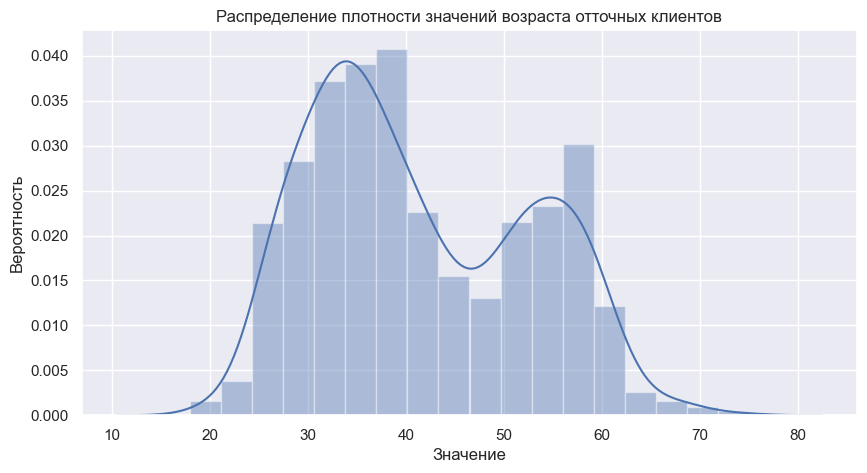

In [77]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.distplot(data_churn['age'], kde=True)
plt.title('Распределение плотности значений возраста отточных клиентов');
plt.xlabel('Значение');
plt.ylabel('Вероятность');

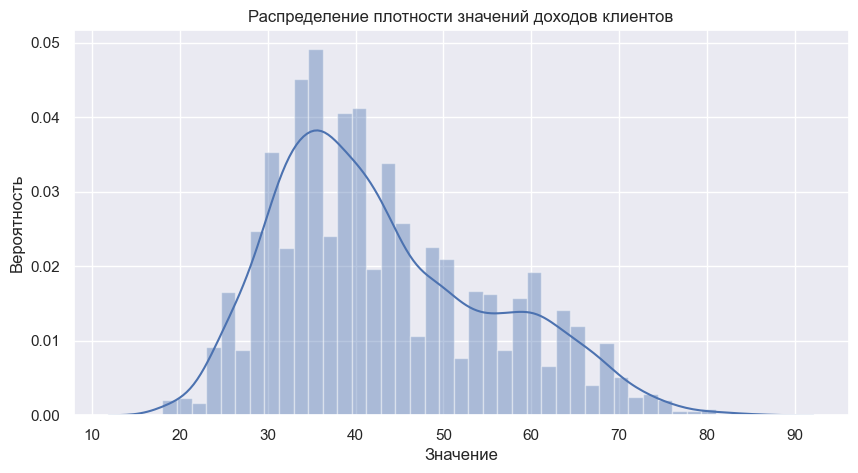

In [78]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.distplot(data_client['age'], kde=True)
plt.title('Распределение плотности значений доходов клиентов');
plt.xlabel('Значение');
plt.ylabel('Вероятность');

Построили гистограммы распределения:
Распределения значений возраста у отточных клиентов не иедально описывает "нормальное" распределение, но с учетом ЦПТ  
***" ... Центральная предельная теорема утверждает, что выборочное распределение среднего значения выборки приблизительно нормально, если размер выборки достаточно велик, даже если распределение населения не является нормальным ... "***   

С учетом того, что наши выборки имеют относительно большое количество наблюдений (более 1000), будем считать, что мы не противоречим использованию t-теста

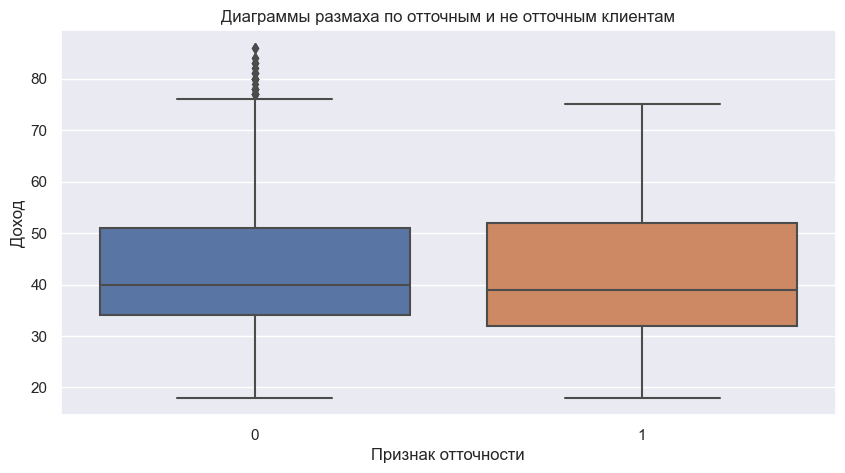

In [79]:
sns.boxplot(data=data, x='churn', y='age')
plt.title('Диаграммы размаха по отточным и не отточным клиентам');
plt.xlabel('Признак отточности');
plt.ylabel('Доход');

По диаграммам размаха видно, что некоторые значения клиентов банка находятся вне третьего квартиля, но они не идиничны и считать их явными выбросами нельзя

***Для проверки гипотезы о том,что средний возраст отточных клиентов ниже, чем у тех кто остается клиентом использую стандартный t-тест Стьюдента т.к.***:
- выборки независимы
- распределения в выборках нормальны, с учетом ЦПТ
- данных полагать, что дисперсии различны нет
- отстутствие явных выбросов в данных

Так как размер выборок отличается более чем на 25%, мы в любом случае настраиваем `equal_var=False` для корректной работы теста.

In [82]:
# Уровень статистической значимости принима. равным 5%
alpha = .05 
results_2 = st.ttest_ind(
    data_churn['age'], 
    data_client['age'],
    equal_var=False,
    alternative='less'
)
print('p-значение -', results_2.pvalue)

if results_2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, есть основания полагать, что средний возраст отточных клиентов ниже')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение - 4.2741187379734e-08
Отвергаем нулевую гипотезу, есть основания полагать, что средний возраст отточных клиентов ниже


In [83]:
churn_age_mean = round(data_churn['age'].mean(), 0)
client_age_mean = round(data_client['age'].mean(), 0)
relative_diff_age = round((1 - churn_age_mean / client_age_mean) * 100, 2)
print(f"Средний возраст отточных клиентов равен {churn_age_mean}")
print(f"Средний возраст клиентов равен {client_age_mean}")
print(f"Относительная разница {relative_diff_age}%")

Средний возраст отточных клиентов равен 41.0
Средний возраст клиентов равен 43.0
Относительная разница 4.65%


Расчетные данные подтверждают результаты статистического теста

###  <font color='red'>**Статистический тест показывает, что на имеющихся данных есть основания полагать, что средний возраст отточных клиентов ниже**</font>

###  <font color='blue'>Подведение промежуточных итогов</font>

***Предобработка данных:***
1. Обработали пропуски -- Заменили пропуски в колонке возраста(MNAR) медианным значением(40), определили пропуски в колонке баланса как MNAR
2. Произвели проверку дубликатов -- явных дубликатов нет, неявные дубликаты по столбца кроме userid и churn отсутствуют. Обнаружены дубликаты по колонке userid (73 дубликата),проверили и выяснили, что, возможно, это связано с обособленным исчислением userid в каждом филиале или техническими ошибками при сборе данных.
3. Провели анализ выбросов -- выбросы не обнаружены

***Исследовательский анализ данных, корреляция:***
1. Для работы с категориальными переменными в исследовательском анализе данных применили метод кодирования категориальных переменных LabelEncoder
2. Построили нормированные гистограммы отточных/ не отточных клиентов по каждому параметру, чтобы определеить интервалы с относительно высокими уровнями отточности
3. Построили матрицы корреляции, матрица с использованием библиотеки phik показала более отчетливую корреляцию, но сильной прямой корреляции между параметрами не обнаружено
4. Построили таблицу типового портрета клиента банка и отточных клиентов, больших усредненных различий не обнаружено

***Статистические гипотезы  
Произвели проверку 2 статистических гипотез с ипользованием ttest:***
1. Гипотеза о том,что доходы клиентов, которые ушли - меньше, чем тех, кто остается клиентом  
***Значение p-value 0.44 - нет оснований отвергать нулевую гипотезу, о том, что средние доходы равны***

  
2. Гипотеза о том,что средний возраст отточных клиентов ниже, чем у тех кто остается клиентом  
***Значение p-value 0.00000036 - при имеющихся данных, есть основания для отвержения нулевой гипотезы и основания полагать, что средний возраст отточных клиентов ниже***

***Признаки влияющие на отточность:***
1. Уровень отточности у мужчин выше, чем у женщин
2. Наибольший уровень отточности у клиентов 24-35 лет, также относительно высокая отточность в возрасте 49-60 лет
3. Высокая отточность у клиентов с баллом крелдитного скоринга 780-930
4. В Ярославле наибольшая отточность клиентов, также высокая в Ростове
5. Уровень отточности выше у клиентов с баллом собственности выше 2 
6. Чем больше продкутов, тем выше уровень отточности, наибольший уровень при количестве продкутов свыше 2
7. Те, у кого нет кредитной карты банка имеют больший уровень отточности
8. Вероятность оттока выше у клиентовс доходом более 100 тыс. руб.

Уровень Коррелляции не показывает сильной прямой зависимости оттока с другими параметрами, но наибольшая корреляция оттока с количеством продуктов, баллами собственности, кредитным скорингом.

###  <font color='blue'>Сегментация</font>

Проведем сегментацию клиентов, на основании провденного анализа по предшествующим пунктам работы  
Выделим несколько сегментов с наибольши уровнем отточности, поясним:
- признаки, по которым образован сегмент
- количественные показатели по сегменту

In [84]:
data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0


In [85]:
churn_rate = data['churn'].mean() * 100
print(f'Изначальный средний процент оттока клиентов банка по всем предоставленным данным составляет {churn_rate}%')

Изначальный средний процент оттока клиентов банка по всем предоставленным данным составляет 18.19181918191819%


Т.к. в задании от заказчика стоит задача сегментирования с сегментами не менее 500 клиентов, даальнейшее применение фильтров нецелесобразно, т.к. оно кратно уменьшает количество клиентов

***Далее разбиваем на несколько подсегментов с сегментированием по различным параметрам:***

In [86]:
data_segment_prod = data.query('(score >= 780 & score <= 900) & products > 2')
display(data_segment_prod.head())
number_records__prod = len(data_segment_prod)
churn_segm_rate_prod = round(data_segment_prod['churn'].mean() * 100, 2)
diff_rate_prod = round(churn_segm_rate_prod - churn_rate, 0)
print(f'Количество клиентов в сегменте prod равно {number_records__prod}')
number_churn_prod = len(data_segment_prod.query('churn ==1'))
print(f'Количество отточных клиентов в сегменте равно {number_churn_prod}')
print('Процент оттока клиентов банка в сегменте prod равен:')
print(f'{churn_segm_rate_prod}%, что на {diff_rate_prod}% выше изначального')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0,0,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0,0,0
26,174396,898.0,Ярославль,Ж,62.0,3,364049.27,3,0,1,50661.84,0,0,0
33,125478,786.0,Ростов,Ж,27.0,3,448062.52,3,1,1,37607.67,0,0,0


Количество клиентов в сегменте prod равно 1052
Количество отточных клиентов в сегменте равно 391
Процент оттока клиентов банка в сегменте prod равен:
37.17%, что на 19.0% выше изначального


In [87]:
data_segment_age = data.query('age >= 24 & age <= 29 & gender == "М"')
display(data_segment_age.head())
number_records_age = len(data_segment_age)
churn_segm_rate_age = round(data_segment_age['churn'].mean() * 100, 2)
diff_rate_age = round(churn_segm_rate_age - churn_rate, 0)
print(f'Количество клиентов в сегменте age равно {number_records_age}')
number_churn_age = len(data_segment_age.query('churn ==1'))
print(f'Количество отточных клиентов в сегменте равно {number_churn_age}')
print('Процент оттока клиентов банка в сегменте age равен:')
print(f'{churn_segm_rate_age}%, что на {diff_rate_age}% выше изначального')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
28,123660,776.0,Ярославль,М,26.0,1,49105.63,1,1,1,38234.94,0,0,0
53,208625,831.0,Ростов,М,28.0,2,75005.22,2,1,0,70283.32,0,0,0
88,210088,894.0,Ярославль,М,29.0,3,786911.18,2,1,1,99022.74,1,0,0
102,116716,797.0,Ростов,М,26.0,2,109453.53,2,0,1,44593.31,0,0,0
103,128618,841.0,Ростов,М,29.0,1,175505.11,4,1,1,48188.69,0,0,0


Количество клиентов в сегменте age равно 627
Количество отточных клиентов в сегменте равно 179
Процент оттока клиентов банка в сегменте age равен:
28.55%, что на 10.0% выше изначального


In [88]:
data_segment_salary = data.query('est_salary >= 100*10**3 & score >= 900 & score <= 930')
display(data_segment_salary.head())
number_records_salary = len(data_segment_salary)
churn_segm_rate_salary = round(data_segment_salary['churn'].mean() * 100, 2)
diff_rate_salary = round(churn_segm_rate_salary - churn_rate, 0)
print(f'Количество клиентов в сегменте salary равно {number_records_salary}')
number_churn_salary = len(data_segment_salary.query('churn ==1'))
print(f'Количество отточных клиентов в сегменте равно {number_churn_salary}')
print('Процент оттока клиентов банка в сегменте salary равен:')
print(f'{churn_segm_rate_salary}%, что на {diff_rate_salary}% выше изначального')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0,0,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,1,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0,1,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0,1,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0,1,0


Количество клиентов в сегменте salary равно 1258
Количество отточных клиентов в сегменте равно 252
Процент оттока клиентов банка в сегменте salary равен:
20.03%, что на 2.0% выше изначального


In [89]:
data_segment_cred = data.query('credit_card == 0')
display(data_segment_cred.head())
number_records_cred = len(data_segment_cred)
churn_segm_rate_cred = round(data_segment_cred['churn'].mean() * 100, 2)
diff_rate_cred = round(churn_segm_rate_cred - churn_rate, 0)
print(f'Количество клиентов в сегменте cred равно {number_records_cred}')
number_churn_cred = len(data_segment_cred.query('churn ==1'))
print(f'Количество отточных клиентов в сегменте равно {number_churn_cred}')
print('Процент оттока клиентов банка в сегменте cred равен:')
print(f'{churn_segm_rate_cred}%, что на {diff_rate_cred}% выше изначального')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0,0,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,1,0
13,166357,837.0,Рыбинск,Ж,28.0,4,302249.22,2,0,1,30950.94,0,0,0


Количество клиентов в сегменте cred равно 3195
Количество отточных клиентов в сегменте равно 816
Процент оттока клиентов банка в сегменте cred равен:
25.54%, что на 7.0% выше изначального


In [90]:
data_segment_city = data.query('city == "Ярославль" & gender == "М" & age >= 29 & age <= 35')
display(data_segment_city.head())
number_records_city = len(data_segment_city)
churn_segm_rate_city = round(data_segment_city['churn'].mean() * 100, 2)
diff_rate_city = round(churn_segm_rate_city - churn_rate, 0)
print(f'Количество клиентов в сегменте city равно {number_records_city}')
number_churn_city = len(data_segment_city.query('churn ==1'))
print(f'Количество отточных клиентов в сегменте равно {number_churn_city}')
print('Процент оттока клиентов банка в сегменте city равен:')
print(f'{churn_segm_rate_city}%, что на {diff_rate_city}% выше изначального')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0
14,172138,815.0,Ярославль,М,35.0,5,547499.87,2,1,1,105883.26,0,0,0
34,205226,944.0,Ярославль,М,35.0,0,NaN,2,1,1,239843.39,0,1,0
45,118849,826.0,Ярославль,М,31.0,4,333330.99,1,1,1,46981.53,0,0,0
77,191976,937.0,Ярославль,М,33.0,5,2061152.96,2,1,1,280670.62,1,0,0


Количество клиентов в сегменте city равно 873
Количество отточных клиентов в сегменте равно 213
Процент оттока клиентов банка в сегменте city равен:
24.4%, что на 6.0% выше изначального


**Создали 5 сегментов клиентов банка, с конечным сегментированием по различным параметрам**  

***Далее приоритизируем сегменты по важности влияния с целью уменьшения оттока в "Метанпром" банке":***
1. Сегмент prod с количеством отточных клиентов 391 и процентом оттока в сегменте 37.17
2. Сегмент city с количеством отточных клиентов 213 и процентом оттока в сегменте 24.4
3. Сегмент cred с количеством отточных клиентов 817 и процентом оттока в сегменте 25.56 (сегмент большой, но есть хорошие точки роста/уменьшения отточности)
4. Сегмент age с количеством отточных клиентов 179 и процентом оттока в сегменте 28.55
5. Сегмент salary с количеством отточных клиентов 252 и процентом оттока в сегменте 20.03


***Приоритизацию провели на основании уровня отточности и количества клиентов в сегменте, а также на возможность влиять на показатель отточности по конечному параметру формирования сегмента***  
Например сегмент с клиентами не имеющими кредитных продуктов/карт, очевидным, сильноффеткивным является улучшение работы по оформлению кредитных продуктов клиентам, что положительно скажется на уменьшении отточности, также по параметру города есть много эффективных партнерских программ в перспективе
(т.е. приоритет был высокому проценту отточности и бОльшему количеству клиентов в сегменте, а также возможность влиять на показатель отточности по конечному параметру формирования сегмента)



In [91]:
print('Вывожу сегменты по порядку приоритизации')
print()
display(data_segment_prod)
print()
display(data_segment_city)
print()
display(data_segment_cred)
print()
display(data_segment_age)
print()
display(data_segment_salary)

Вывожу сегменты по порядку приоритизации



,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0,0,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0,0,0
26,174396,898.0,Ярославль,Ж,62.0,3,364049.27,3,0,1,50661.84,0,0,0
33,125478,786.0,Ростов,Ж,27.0,3,448062.52,3,1,1,37607.67,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9962,217489,893.0,Ярославль,Ж,49.0,5,1571192.11,4,1,1,151217.99,1,0,0
9970,175730,816.0,Рыбинск,М,36.0,4,477892.07,3,1,0,81100.60,0,0,0
9988,158678,889.0,Ярославль,М,35.0,4,880534.89,4,1,1,126564.61,0,0,0
9989,215485,860.0,Ярославль,Ж,67.0,4,637403.26,3,0,0,37469.87,0,0,0


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0
14,172138,815.0,Ярославль,М,35.0,5,547499.87,2,1,1,105883.26,0,0,0
34,205226,944.0,Ярославль,М,35.0,0,NaN,2,1,1,239843.39,0,1,0
45,118849,826.0,Ярославль,М,31.0,4,333330.99,1,1,1,46981.53,0,0,0
77,191976,937.0,Ярославль,М,33.0,5,2061152.96,2,1,1,280670.62,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9967,121752,995.0,Ярославль,М,30.0,1,59100.34,2,1,1,55575.88,0,0,0
9978,218170,841.0,Ярославль,М,29.0,2,235287.10,2,1,1,137494.06,1,0,0
9985,190822,801.0,Ярославль,М,29.0,0,34300.30,2,1,1,107483.12,0,0,0
9988,158678,889.0,Ярославль,М,35.0,4,880534.89,4,1,1,126564.61,0,0,0


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0,0,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,1,0
13,166357,837.0,Рыбинск,Ж,28.0,4,302249.22,2,0,1,30950.94,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9986,152986,822.0,Ярославль,М,58.0,5,1434857.91,2,0,1,83442.41,1,0,0
9989,215485,860.0,Ярославль,Ж,67.0,4,637403.26,3,0,0,37469.87,0,0,0
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0,0,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0,0,0


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
28,123660,776.0,Ярославль,М,26.0,1,49105.63,1,1,1,38234.94,0,0,0
53,208625,831.0,Ростов,М,28.0,2,75005.22,2,1,0,70283.32,0,0,0
88,210088,894.0,Ярославль,М,29.0,3,786911.18,2,1,1,99022.74,1,0,0
102,116716,797.0,Ростов,М,26.0,2,109453.53,2,0,1,44593.31,0,0,0
103,128618,841.0,Ростов,М,29.0,1,175505.11,4,1,1,48188.69,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974,160702,919.0,Рыбинск,М,26.0,0,NaN,1,1,1,187423.66,0,1,0
9978,218170,841.0,Ярославль,М,29.0,2,235287.10,2,1,1,137494.06,1,0,0
9985,190822,801.0,Ярославль,М,29.0,0,34300.30,2,1,1,107483.12,0,0,0
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0,0,0


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,missed_age
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0,0,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,1,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0,1,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0,1,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9966,120996,908.0,Рыбинск,Ж,68.0,0,NaN,1,1,1,146253.81,0,1,0
9969,123120,910.0,Ярославль,Ж,64.0,0,NaN,2,1,1,165340.00,0,1,0
9974,160702,919.0,Рыбинск,М,26.0,0,NaN,1,1,1,187423.66,0,1,0
9975,212027,918.0,Рыбинск,Ж,34.0,1,226375.21,2,1,1,208353.35,0,0,0


##  <font color='blue'>Выводы по анализу</font>

### В своей работе я получил данные от крупного регионального банка "Метанпром".  
### Целью работы является анализ и выявление параметров, которые могут влиять на отточность клиентов.   
### Сегментация клиентов с уровнем оттока выше, чем в среднем по банку и вывод рекомендаций по уменьшению отточности клиентов

В процессе работы мы провели:
- ***Предобработку данных***
- ***Анализ данных, количественные показатели***
- ***Проверку статистических гипотез***
- ***Сегментацию клиентов***

##  <font color='green'>Рекомендации по уменьшению отточности по сегментам:</font>
  
Каждый сегмент конечно формировался на основании определенного признака, который в сильной мере влиял на отточность и на колимчество клиентов в сегменте. Но также перед конечно разбивкой групп на сегменты изначальный датасет фильтровался по параметрам, которые имеют заметное влияние на показатель отточности:
- Гендер мужской
- Интервал кредитного рейтинга от 780 до 930
- Количество баллов собственности выше 2
Будем учитывать эти параметры при формировании окончательных рекомендаций для уменьшения отточности в разрезе сегментов  
  
 1. Сегмент с клиентами не имеющими кредитных карт -  **Усиляем работы по оформлению кредитных продуктво мужскому полу. Запускаем рассылку с "Бесплатным обслуживанием кредитной и жебетовой карты при оформлении кредитного продукта (в т.ч. кредитной карты) до конца месяца. А также повышаем бонусы для сотрудников, которые выполняют план по оформлению кредитных продуктов клиентам.**
 2. Сегмент с клиентами с доходом выше 100 000 р. - сегмент, на который не так очевидно и сто процентно эффективно можно влиять, но это важный сегмент с большим процентом отточности и большим количеством клиентов. **Рекомендация - повышаем ставки по вкладам с номиналом выше 500 000, Повышаем процент на остаток на карте более 100 000**
 3. Сегмент с клиентами из г.Ярославль - сегмент, на который можно более очеивдно и эффективно влиять. **Рекомендация - делаем партнерский проект с сетью барбершопов "Ярославич" и с футбольным клубом "Шинник", при оформлении кредитного продукта в "Метанпром" банке, стрижка бороды и абонемент на матчи Шинника бесплатны.
 4. Сегмент с клиентами, у которых количество продуктов более 2 - возможно отточность в этом сегменте связана с очень высокими долговыми обязательствами или чемто похожим. **Рекомендация - дать установку отделу продаж более тщательно оценивать риски при оформлении 3 и более продукта клиенту**
 5. Сегмент с клиентами в возрасте от 24 до 35 лет - Чаще всего это выпускники вузов, молодые пары, молодожены. **Рекомендация - Делаем партнерскую программу с популярным молодежным сериалом и запуском таргетированной рекламы на такой возрастной интервал, Уменьшаем ставки по ипотеке и кредитам для молодых семей и выпускников вузов в нужно нам возрастном интервале**
  
  

